In [1]:
import pandas as pd
import plotly.express as px
import us
import requests
import seaborn as sns
from bs4 import BeautifulSoup

In [2]:
#Load in the original csv file that shows the 2023 household income
df = pd.read_csv("data.csv")
df = df.drop(columns=["fips", "densityMi", "pop2022", "pop2020", "pop2019", "pop2010", "growthRate", "growth", "growthSince2010"])
df.head()

state  pop2023  HouseholdIncome
0  District of Columbia   674815            90842
1              Maryland  6154710            87063
2            New Jersey  9255437            85245
3         Massachusetts  6974258            84385
4                Hawaii  1433238            83173

In [3]:
# Group the data frame by state and calculate the mean of the HouseholdIncome column
df = df.groupby("state").mean().reset_index()
df.head()

state     pop2023  HouseholdIncome
0     Alabama   5098746.0          52035.0
1      Alaska    732984.0          77790.0
2     Arizona   7453517.0          61529.0
3    Arkansas   3063152.0          49475.0
4  California  38915693.0          78672.0

In [4]:
# Remove commas from data format and convert to numeric data type so it can be used later
df["HouseholdIncome"] = pd.to_numeric(df["HouseholdIncome"].astype(str).str.replace(",", ""))
df = df[(df["HouseholdIncome"] >= 10000) & (df["HouseholdIncome"] <= 200000)]
df = df.groupby("state").median().reset_index()
df.head()

state     pop2023  HouseholdIncome
0     Alabama   5098746.0          52035.0
1      Alaska    732984.0          77790.0
2     Arizona   7453517.0          61529.0
3    Arkansas   3063152.0          49475.0
4  California  38915693.0          78672.0

In [5]:
#Connect abreviations to each state, so I can create US Map
us.states.lookup("Florida").abbr
df["abbr"] = df["state"].map(lambda s:us.states.lookup(s).abbr)
df.head()

state     pop2023  HouseholdIncome abbr
0     Alabama   5098746.0          52035.0   AL
1      Alaska    732984.0          77790.0   AK
2     Arizona   7453517.0          61529.0   AZ
3    Arkansas   3063152.0          49475.0   AR
4  California  38915693.0          78672.0   CA

In [6]:
#read in url so web scraping can occur 
url = "https://www.talent.com/salary?job=data+scientist"
page = requests.get(url)
soup = BeautifulSoup(page.content, "html.parser")

In [7]:
# Find the div containing  salary information
salary_div = soup.find("div", {"class": "l-card__container-avg-salary"})

In [8]:
# Extract state and salary for each state by using BeuatifulSoup 
states = []
per_years = []

#For loop to iterate through each card
for card in salary_div.find_all("a", {"class": "l-card--progressBar--row"}):
    state = card.find("div", {"class": "c-card--progressBar--text --textEllipsis"}).text.strip()
    per_year = card.find("div", {"class": "c-card--progressBar--number timeBased"})["peryear"].strip("$").replace(",", "")
    states.append(state)
    per_years.append(per_year)

In [9]:
# Create a DataFrame with the extracted information
df2 = pd.DataFrame({"state": states, "Salary Per Year": per_years})
df2.head()

state Salary Per Year
0   California          150003
1     New York          150000
2     Delaware          146600
3  Connecticut          146550
4   Washington          144400

In [10]:
#Merge dataframes
combined_df = pd.merge(df, df2, on='state')

In [11]:
#Clean up dataframe
combined_df = combined_df.rename(columns={"state": "State", "pop2023": "Current Population", "HouseholdIncome": "Median Household Income", "abbr": "State Code", "Salary Per Year": "Data Scientist Salary(USD)"})
combined_df.head()

State  Current Population  Median Household Income State Code  \
0     Alabama           5098746.0                  52035.0         AL   
1      Alaska            732984.0                  77790.0         AK   
2     Arizona           7453517.0                  61529.0         AZ   
3    Arkansas           3063152.0                  49475.0         AR   
4  California          38915693.0                  78672.0         CA   

  Data Scientist Salary(USD)  
0                     111000  
1                     138550  
2                     125000  
3                     136300  
4                     150003

In [12]:
#Get url that contains Upper Class income
url = "https://www.usatoday.com/story/money/2020/11/20/income-it-takes-to-be-considered-rich-in-every-state/114967522/"
page = requests.get(url)
soup = BeautifulSoup(page.content, "html.parser")

In [13]:
state_list = []
annual_income_list = []

In [14]:
# Extract state and annual income information
income_tags = soup.select("p.gnt_ar_b_p")
for income_tag in income_tags:
    income_text = income_tag.text.strip()
    if "Annual income needed to be in the top 20% of earners" in income_text:
        annual_income_str = income_text.split(":")[-1].strip().replace(",", "").replace("$", "").split(" ")[0]
        annual_income = int(annual_income_str)
        annual_income_list.append(annual_income)
        state_tag = income_tag.find_previous_sibling("h3", class_="gnt_ar_b_h2")
        state_name = state_tag.text.strip()
        state_list.append(state_name)

In [15]:
# Create dataframe
df = pd.DataFrame({"State": state_list, "Annual Income for Top 20% Earners": annual_income_list})
df.head()

State  Annual Income for Top 20% Earners
0     Alabama                             106225
1      Alaska                             144736
2     Arizona                             120982
3    Arkansas                              98014
4  California                             162657

In [16]:
#Update Main dataframe with new info
combined_df = pd.merge(combined_df, df, on='State')
combined_df.head()

State  Current Population  Median Household Income State Code  \
0     Alabama           5098746.0                  52035.0         AL   
1      Alaska            732984.0                  77790.0         AK   
2     Arizona           7453517.0                  61529.0         AZ   
3    Arkansas           3063152.0                  49475.0         AR   
4  California          38915693.0                  78672.0         CA   

  Data Scientist Salary(USD)  Annual Income for Top 20% Earners  
0                     111000                             106225  
1                     138550                             144736  
2                     125000                             120982  
3                     136300                              98014  
4                     150003                             162657

In [24]:
#Clean datframe
combined_df = combined_df.rename(columns={'Annual Income for Top 20% Earners_y': 'Upper Class'})
combined_df.head()

State  Current Population  Median Household Income State Code  \
0     Alabama           5098746.0                  52035.0         AL   
1      Alaska            732984.0                  77790.0         AK   
2     Arizona           7453517.0                  61529.0         AZ   
3    Arkansas           3063152.0                  49475.0         AR   
4  California          38915693.0                  78672.0         CA   

  Data Scientist Salary(USD)  Upper Class Middle Class Income  PovertyRate  
0                     111000       106225               45559     0.149574  
1                     138550       144736               63873     0.101461  
2                     125000       120982               61699     0.132894  
3                     136300        98014               40928     0.153499  
4                     150003       162657              111206     0.124717

In [25]:
#Scrape the middle class info
url = "https://www.zippia.com/advice/how-much-money-is-middle-class/"
html = requests.get(url).content

df_list = pd.read_html(html)
df = df_list[1]  # The second table is index 1 in the list of tables

df.columns = ["State", "Middle Class Income", "Lower Limit", "Upper Limit", "Average Monthly Expenses"]
df = df.drop(columns=["Lower Limit", "Upper Limit", "Average Monthly Expenses"])

df.head()


State Middle Class Income
0         Hawaii            $122,695
1     California            $111,206
2  Massachusetts             $85,567
3       Colorado             $81,602
4     Washington             $81,203

In [26]:
#Update dataframe
combined_df = pd.merge(combined_df, df, on='State')
combined_df = combined_df.rename(columns={'Annual Income for Top 20% Earners': 'Upper Class'})
combined_df.head()

State  Current Population  Median Household Income State Code  \
0     Alabama           5098746.0                  52035.0         AL   
1      Alaska            732984.0                  77790.0         AK   
2     Arizona           7453517.0                  61529.0         AZ   
3    Arkansas           3063152.0                  49475.0         AR   
4  California          38915693.0                  78672.0         CA   

  Data Scientist Salary(USD)  Upper Class Middle Class Income_x  PovertyRate  \
0                     111000       106225                 45559     0.149574   
1                     138550       144736                 63873     0.101461   
2                     125000       120982                 61699     0.132894   
3                     136300        98014                 40928     0.153499   
4                     150003       162657                111206     0.124717   

  Middle Class Income_y  
0               $45,559  
1               $63,873  
2               $61,699  
3               $40,928  
4              $111,206

In [27]:
#Use pandas to read in datafram
df = pd.read_csv("povertyLine.csv")
df = df.drop(columns=["fips", "densityMi", "pop2023", "pop2022", "pop2020", "pop2019", "pop2010", "growthRate", "growth", "growthSince2010", "undefined", "rank"])
df = df.rename(columns={'state': 'State'})
df.head()

State  PovertyRate
0    Mississippi     0.192607
1      Louisiana     0.185627
2     New Mexico     0.180580
3  West Virginia     0.170078
4       Kentucky     0.158896

In [21]:
#update main datafram
combined_df = pd.merge(combined_df, df, on='State')
combined_df.head()

State  Current Population  Median Household Income State Code  \
0     Alabama           5098746.0                  52035.0         AL   
1      Alaska            732984.0                  77790.0         AK   
2     Arizona           7453517.0                  61529.0         AZ   
3    Arkansas           3063152.0                  49475.0         AR   
4  California          38915693.0                  78672.0         CA   

  Data Scientist Salary(USD)  Upper Class Middle Class Income  PovertyRate  
0                     111000       106225             $45,559     0.149574  
1                     138550       144736             $63,873     0.101461  
2                     125000       120982             $61,699     0.132894  
3                     136300        98014             $40,928     0.153499  
4                     150003       162657            $111,206     0.124717

In [22]:
combined_df['Middle Class Income'] = combined_df['Middle Class Income'].str.replace('$', '', regex=False).str.replace(',', '', regex=False)
combined_df.head()

State  Current Population  Median Household Income State Code  \
0     Alabama           5098746.0                  52035.0         AL   
1      Alaska            732984.0                  77790.0         AK   
2     Arizona           7453517.0                  61529.0         AZ   
3    Arkansas           3063152.0                  49475.0         AR   
4  California          38915693.0                  78672.0         CA   

  Data Scientist Salary(USD)  Upper Class Middle Class Income  PovertyRate  
0                     111000       106225               45559     0.149574  
1                     138550       144736               63873     0.101461  
2                     125000       120982               61699     0.132894  
3                     136300        98014               40928     0.153499  
4                     150003       162657              111206     0.124717

In [23]:
Data Visualization

SyntaxError: invalid syntax (1317073656.py, line 1)

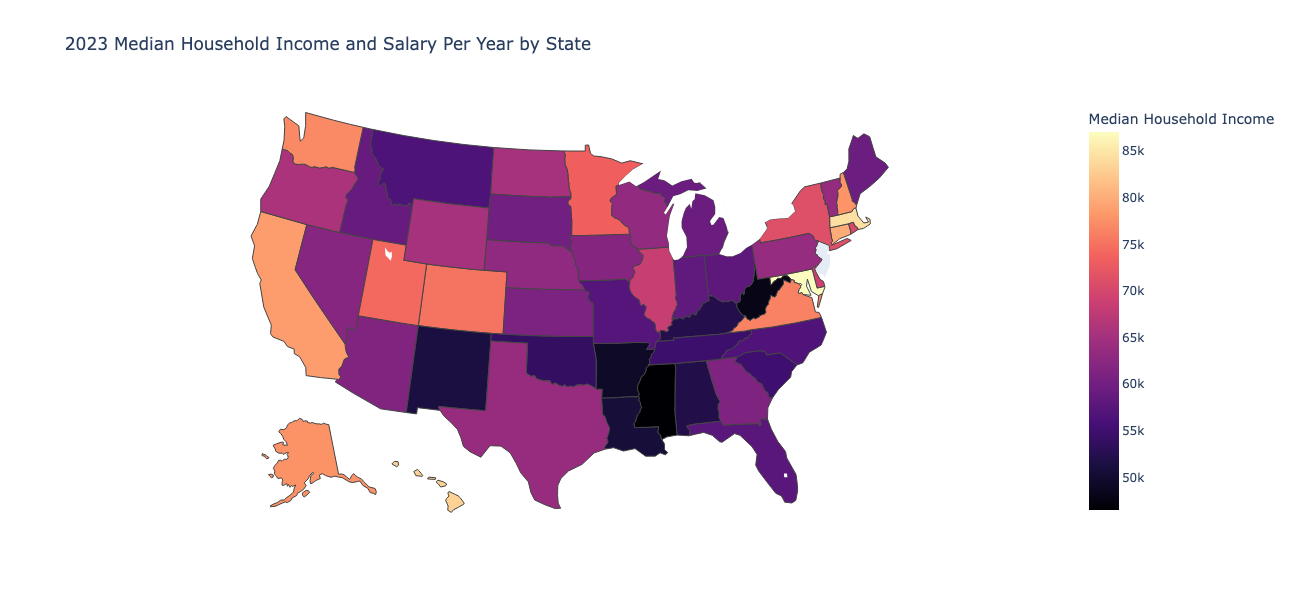

In [24]:
fig = px.choropleth(combined_df, 
                    locations="State Code", 
                    locationmode="USA-states", 
                    scope="usa",
                    color="Median Household Income",
                    hover_name="State",
                    title="Median Household Income and Data Scientist Average Salary",
                    color_continuous_scale=px.colors.sequential.Magma
                   )

fig.update_layout(dragmode=False)

fig.update_traces(
    hovertemplate='<b>%{hovertext}</b><br><br>' +
        'Median Household Income: $%{z:,}<br>' +
        'Data Scientist Average Salary: $%{customdata:,}<extra></extra>',
    customdata=combined_df["Data Scientist Salary(USD)"]
)

fig.update_layout(
    title="2023 Median Household Income and Salary Per Year by State",
    geo=dict(scope="usa"),
    width=1000, 
    height=600,
    hoverlabel=dict(
        bgcolor="white",
        font_size=16,
        font_family="Helvetica"
    )
)

# Show the plot
fig.show()

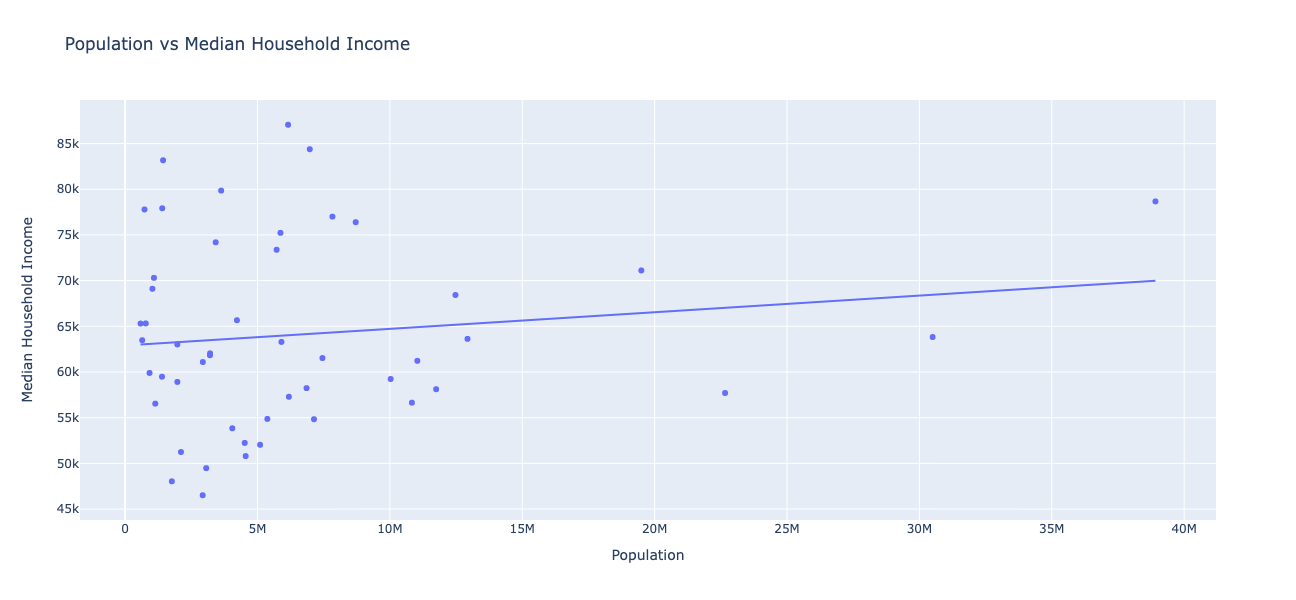

In [25]:
fig = px.scatter(combined_df, x="Current Population", y="Median Household Income", hover_name="State", title="Population vs Median Household Income",trendline = "ols")
fig.update_layout(
    xaxis_title="Population",
    yaxis_title="Median Household Income",
    width=1000,
    height=600,
    hoverlabel=dict(
        bgcolor="white",
        font_size=16,
        font_family="Helvetica"
    )
)

fig

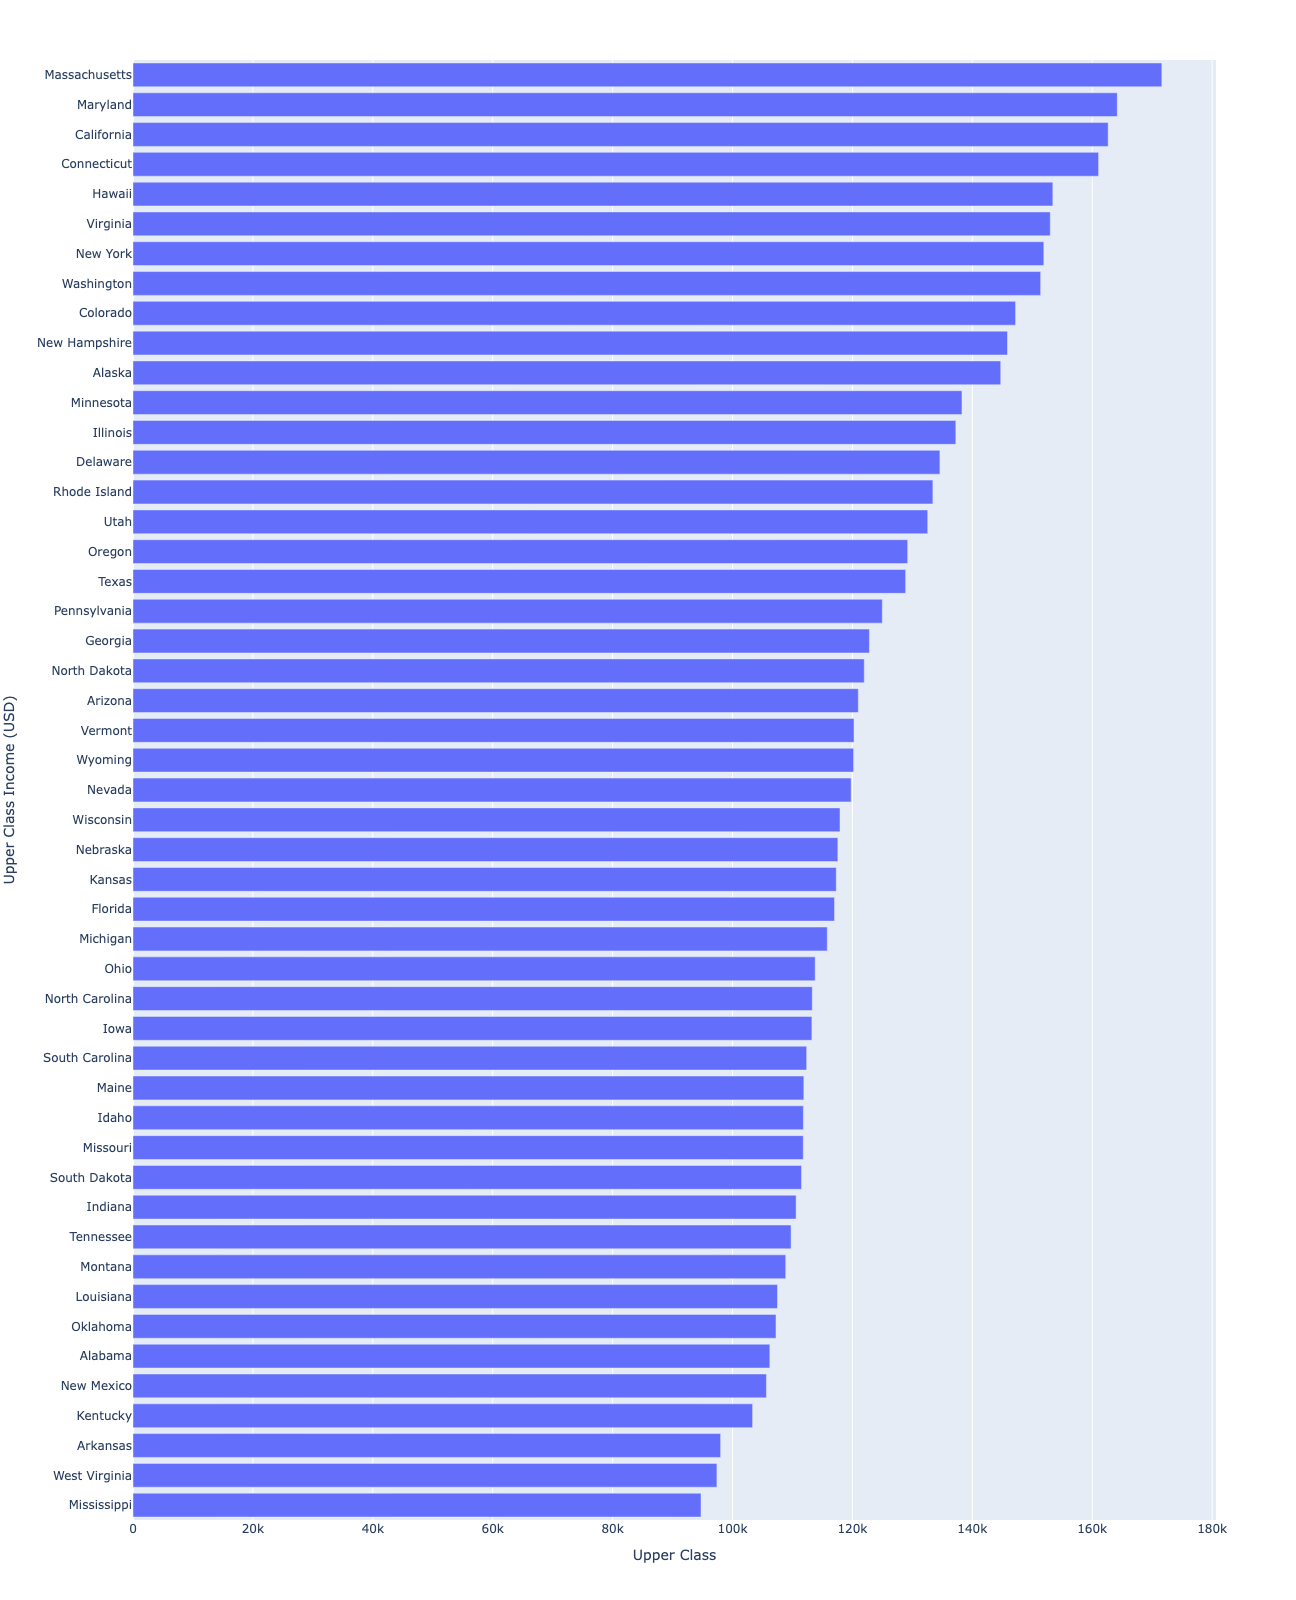

In [26]:
# sort the data in descending order
combined_df = combined_df.sort_values("Upper Class", ascending=True)

# create the horizontal bar plot for upper class income
fig = px.bar(combined_df, x="Upper Class", y="State", orientation="h")
fig.update_layout(height=1600, width=800, yaxis=dict(range=[-0.5, len(combined_df["State"])-0.5]), yaxis_title="Upper Class Income (USD)")

fig

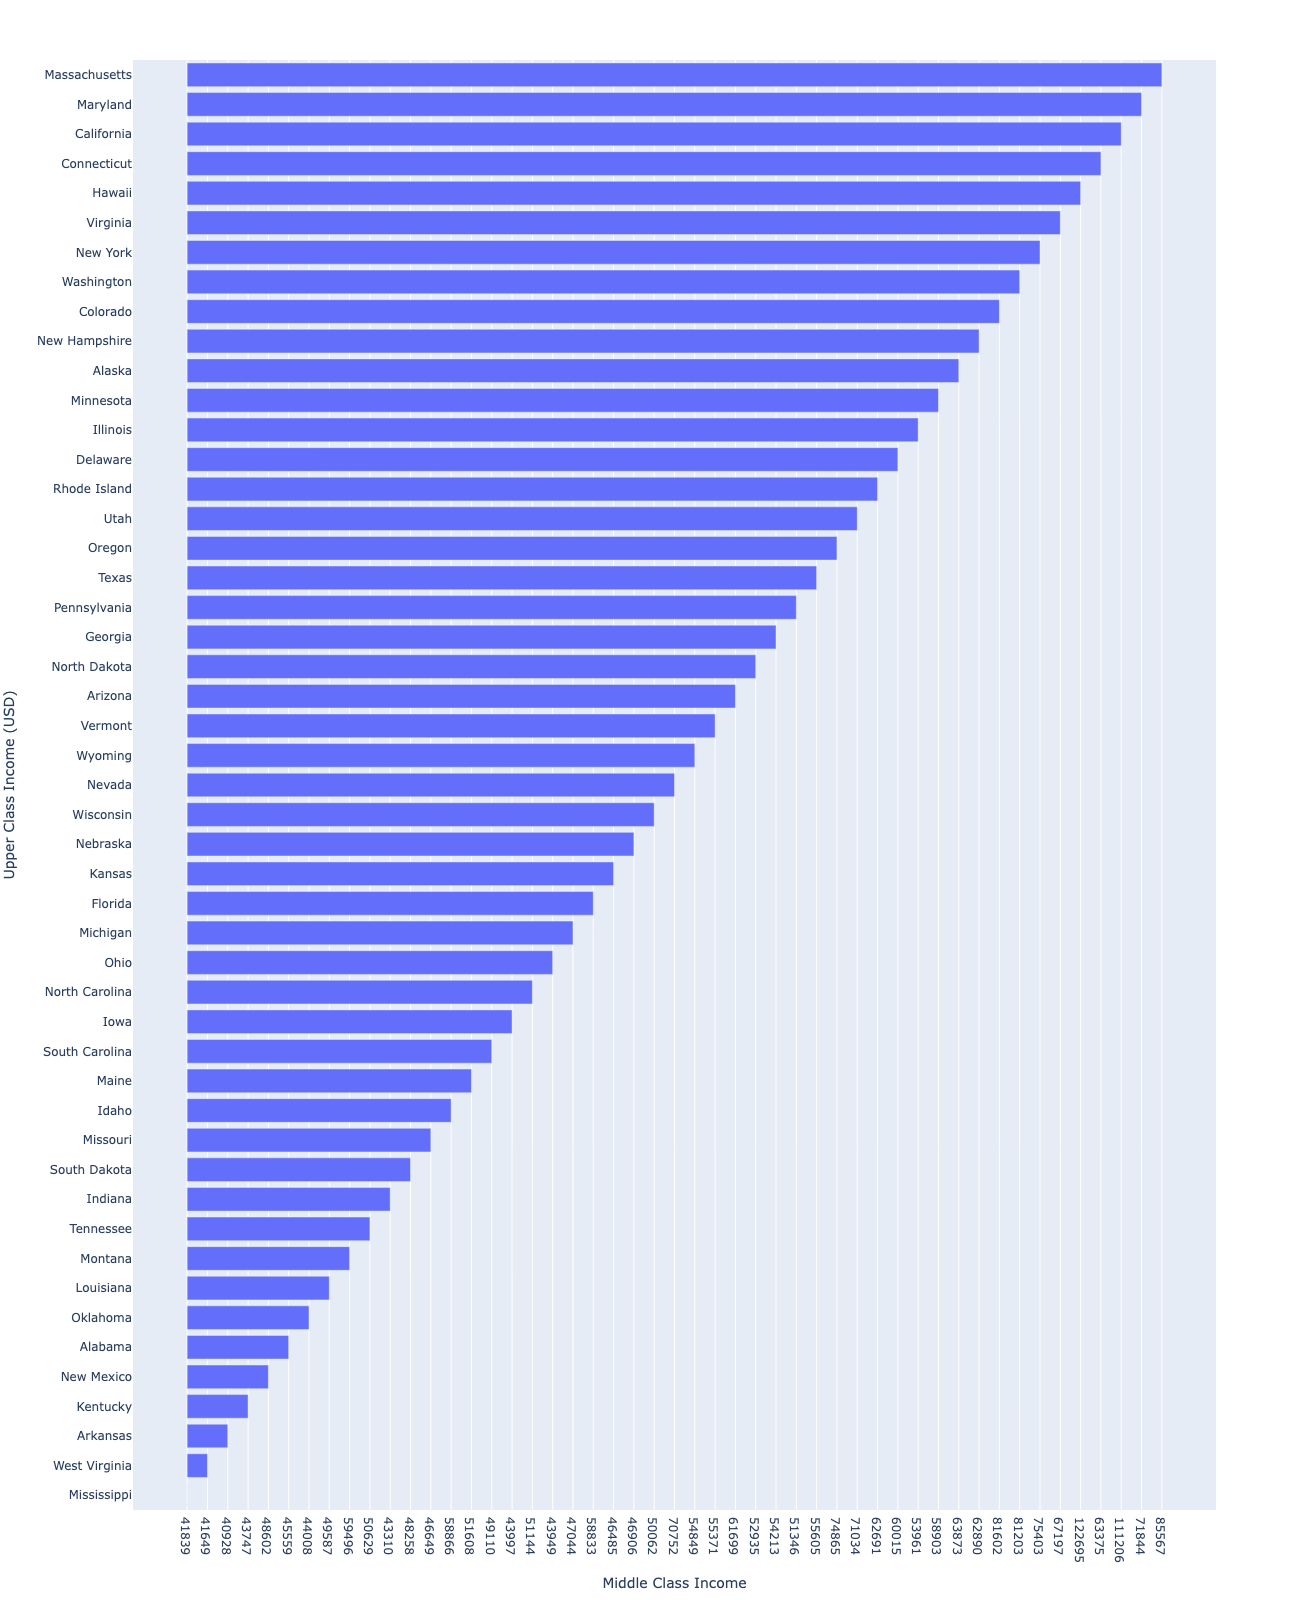

In [27]:
# create the horizontal bar plot for upper class income
fig = px.bar(combined_df, x="Middle Class Income", y="State", orientation="h")
fig.update_layout(height=1600, width=800, yaxis=dict(range=[-0.5, len(combined_df["State"])-0.5]), yaxis_title="Upper Class Income (USD)")

fig

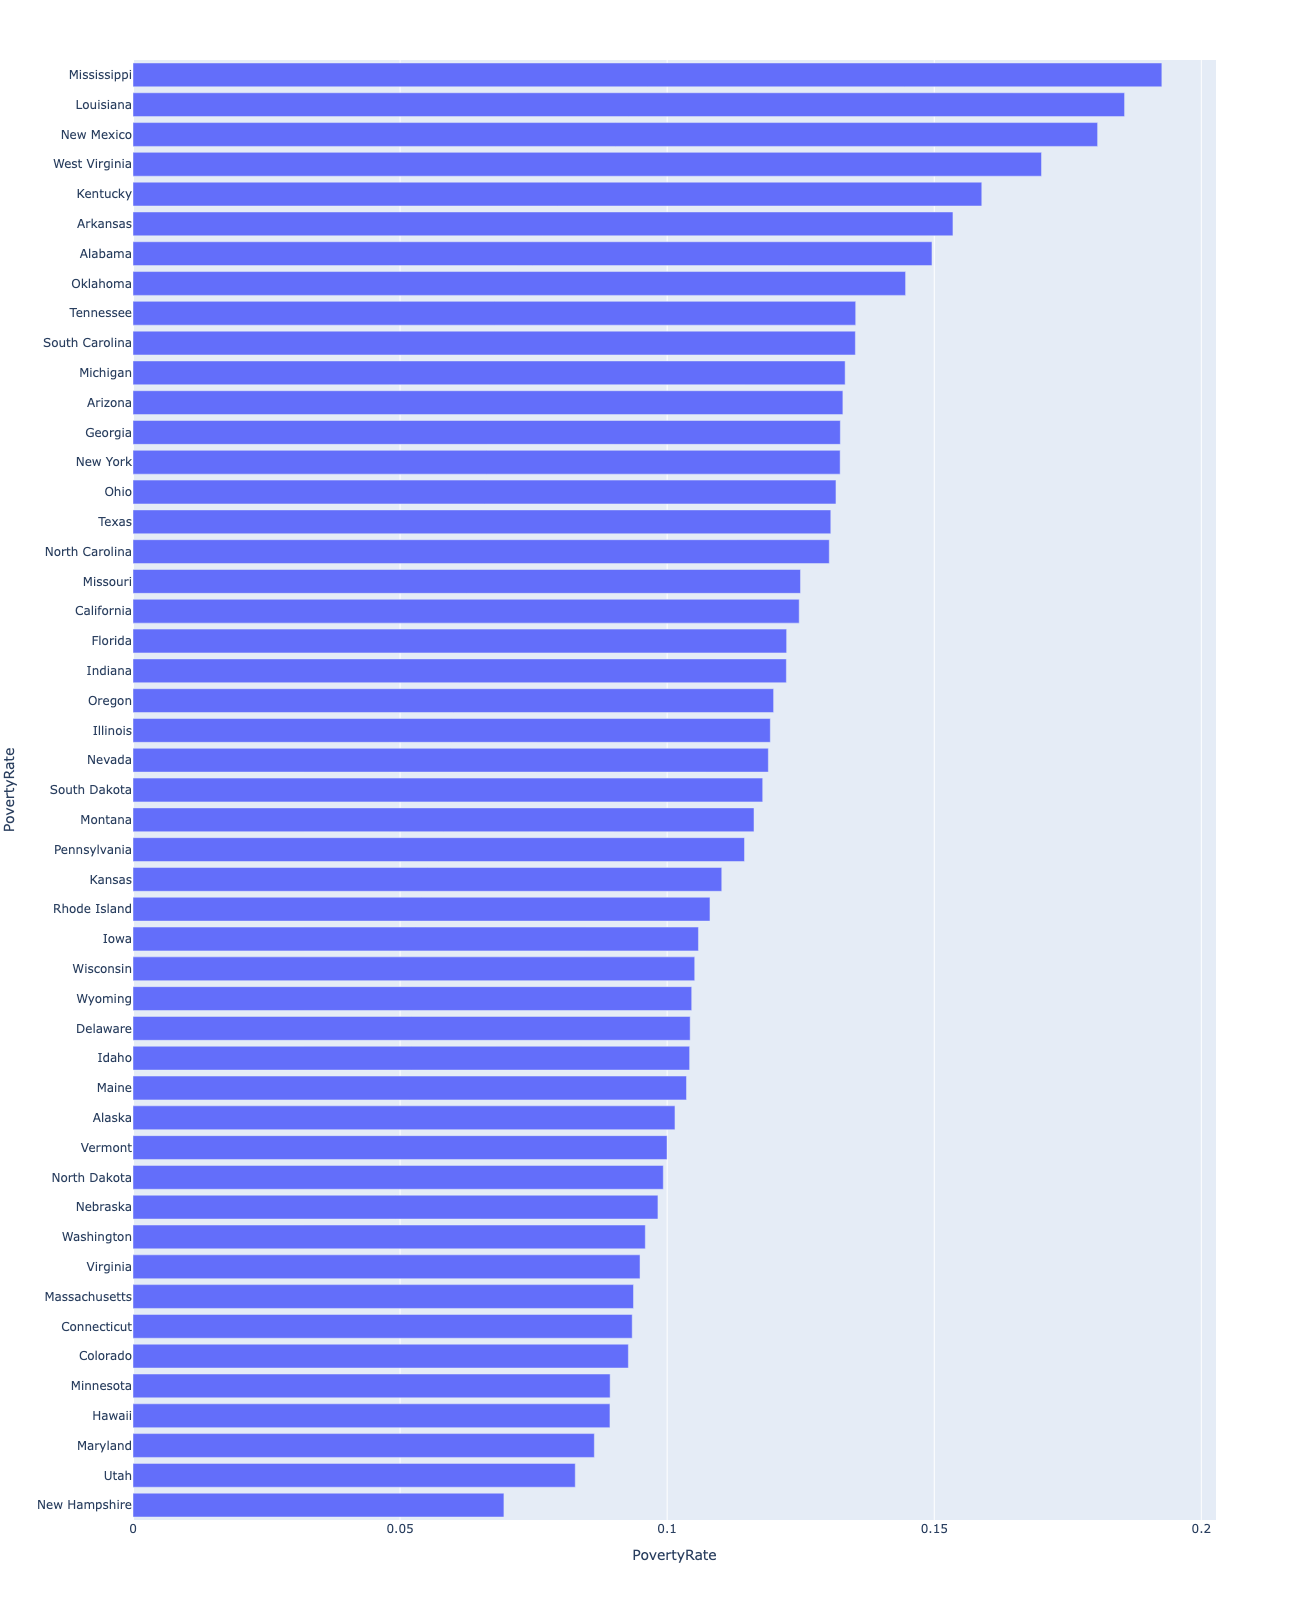

In [28]:
# sort the data in descending order
combined_df = combined_df.sort_values("PovertyRate", ascending=True)

# create the horizontal bar plot for upper class income
fig = px.bar(combined_df, x="PovertyRate", y="State", orientation="h")
fig.update_layout(height=1600, width=800, yaxis=dict(range=[-0.5, len(combined_df["State"])-0.5]), yaxis_title="PovertyRate")

fig